In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import InputLayer, Dense, Layer
import numpy as np
import matplotlib.pyplot as plt
import time

np.random.seed(234)
tf.random.set_seed(234)

In [2]:
class ShiftLayer(Layer):
    """A layer for shifting the input by pre-defined domain bounds t_min, t_max"""
    def __init__(self, t_min, t_max):
        super().__init__()
        self.t_min = t_min
        self.t_max = t_max

    def call(self, inputs):
        return 2.0 * (inputs - self.t_min) / (self.t_max - self.t_min) - 1.0


class NeuralNet:
    # Initialize the class
    def __init__(self, t_train, x_train, t_test, x_test, layers, t_min, t_max):
        self.t_train = t_train
        self.x_train = x_train
        self.t_test = t_test
        self.x_test = x_test
        self.loss_history = {"train": [], "test": []}
        
        # Initialize NNs with given number of layers and domain bounds [t_min, tmax]
        self.net = self.create_mlp(t_min, t_max, layers)
    
    @tf.function
    def loss_train(self):
        x_pred = self.net(self.t_train)
        loss = tf.reduce_mean(tf.square(self.x_train - x_pred)) * 10
        return loss
    
    @tf.function
    def loss_test(self):
        x_pred = self.net(self.t_test)
        loss = tf.reduce_mean(tf.square(self.x_test - x_pred)) * 10
        return loss

    def get_test_error(self):
        x_pred = self.net(self.t_test)
        error_x = tf.norm(self.x_test - x_pred, 2) / tf.norm(self.x_test, 2)
        return error_x

    def create_mlp(self, lt, ut, layers):
        """Create the neural net (multilayer perceptron)

        Note:
            Tensorflow provides a convenient programming interface called tf.keras.
            Use tf.keras to create model could save much effort for manually creating/initializing weights .etc.
        """
        model = tf.keras.Sequential()
        model.add(InputLayer(input_shape=(1,), dtype=tf.float32))
        model.add(ShiftLayer(lt, ut))
        model.add(Dense(layers[0], activation=tf.sin, dtype=tf.float32, kernel_initializer="glorot_normal"))
        for n_unit in layers[1:-1]:
            model.add(Dense(n_unit, activation=tf.sin, dtype=tf.float32, kernel_initializer="glorot_normal"))
        model.add(Dense(layers[-1], activation=None, dtype=tf.float32, kernel_initializer="glorot_normal"))
        return model

    def train(self, nIter: int, learning_rate: float, idxOpt: int):
        """Function used for training the model"""
        if idxOpt == 1:
            # mode 1: running the Gradient Descent optimization
            self.optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
        elif idxOpt == 2:
            # mode 2: running the Adam optimization
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        else:
            raise ValueError("Unsupported idxOpt")

        varlist = self.net.trainable_variables
        start_time = time.time()

        for it in range(nIter):
            self.optimizer.minimize(self.loss_train, varlist)
            
            # Print
            if it % 100 == 0:
                elapsed = time.time() - start_time
                loss_train = self.loss_train().numpy()
                loss_test = self.loss_test().numpy()
                self.loss_history["train"].append(loss_train)
                self.loss_history["test"].append(loss_test)
                print('It: %d, Train Loss: %.3e, Test Loss: %.3e, Time: %.2f' % 
                      (it, loss_train, loss_test, elapsed))
                start_time = time.time()

In [3]:
%matplotlib inline
def plot(t_all, x_all, pred_all, t_test, x_test, title: str):
    fig = plt.figure(figsize=(21, 24))

    ax = plt.subplot(311)
    ax.plot(t_all, x_true, "r", label="Exact Solution")
    ax.plot(t_all, pred_all, "b--", label="Prediction")
    ax.scatter(t_test, x_test, s=30, c="g", label="Test Data Point")
    ax.legend()
    ax.set_xlabel("$t$", fontsize = 12)
    ax.set_ylabel("$x$", fontsize = 12, rotation = 0)
    ax.set_title("$Fitting$", fontsize = 15)

    ax = plt.subplot(312)
    ax.plot(t_all, pred_all - x_true, "b-")
    ax.set_xlabel("$t$", fontsize = 12)
    ax.set_ylabel("Prediction - Exact Solution", fontsize = 12, rotation = 90)
    ax.set_title("Difference between Prediction and Exact Solution", fontsize = 15)

    ax = plt.subplot(313)
    loss_train = np.array(model.loss_history["train"])
    loss_test = np.array(model.loss_history["test"])
    ax.scatter(np.arange(loss_train.size) * 100, loss_train, s=30, marker="x", label="Train Loss")
    ax.scatter(np.arange(loss_train.size) * 100, loss_test, s=30, marker="+", label="Test Loss")
    ax.legend()
    ax.set_xlabel("$iterations$", fontsize = 12)
    ax.set_ylabel("Loss", fontsize = 12, rotation = 90)
    ax.set_yscale("log")
    ax.set_title('Loss Curve', fontsize = 15)
    
    plt.gcf().text(0.02, 0.9, title, fontsize=20)

It: 0, Train Loss: 5.147e+00, Test Loss: 4.743e+00, Time: 0.77
It: 100, Train Loss: 5.086e+00, Test Loss: 4.656e+00, Time: 0.60
It: 200, Train Loss: 5.041e+00, Test Loss: 4.616e+00, Time: 0.60
It: 300, Train Loss: 4.837e+00, Test Loss: 4.510e+00, Time: 0.61
It: 400, Train Loss: 4.440e-03, Test Loss: 3.990e-03, Time: 0.68
It: 500, Train Loss: 1.015e-03, Test Loss: 7.841e-04, Time: 0.66
It: 600, Train Loss: 1.014e-03, Test Loss: 7.833e-04, Time: 0.66
It: 700, Train Loss: 1.013e-03, Test Loss: 7.826e-04, Time: 0.62
It: 800, Train Loss: 1.012e-03, Test Loss: 7.819e-04, Time: 0.69
It: 900, Train Loss: 1.011e-03, Test Loss: 7.811e-04, Time: 0.62
It: 1000, Train Loss: 1.010e-03, Test Loss: 7.804e-04, Time: 0.62
It: 1100, Train Loss: 1.009e-03, Test Loss: 7.797e-04, Time: 0.62
It: 1200, Train Loss: 1.009e-03, Test Loss: 7.789e-04, Time: 0.61
It: 1300, Train Loss: 1.008e-03, Test Loss: 7.782e-04, Time: 0.64
It: 1400, Train Loss: 1.007e-03, Test Loss: 7.775e-04, Time: 0.59
It: 1500, Train Loss: 

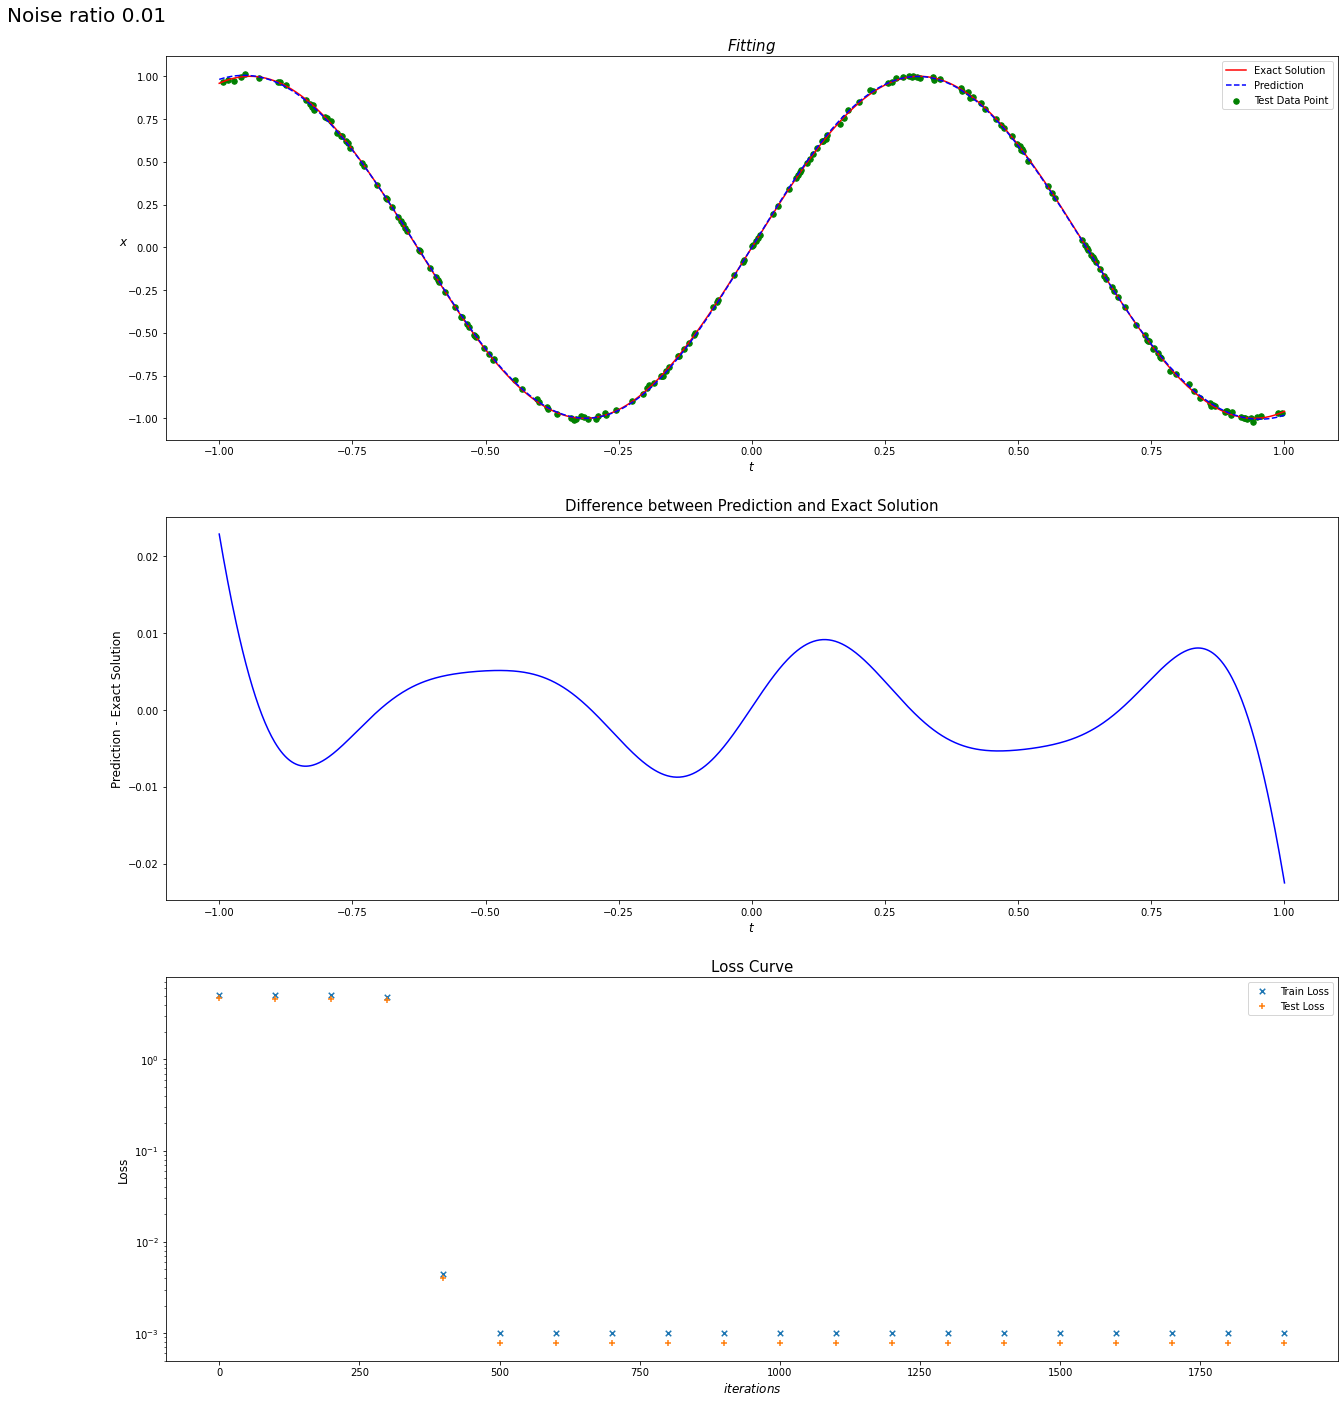

In [4]:
# Create data points and get random split of train, test data sets by index slicing
n_total = 1000
train_ratio = 0.8
n_train = int(n_total * train_ratio)

t_all = np.linspace(-1, 1, n_total)
noise = np.random.normal(loc=0.0, scale=0.01, size=t_all.shape)
x_all = np.sin(5 * t_all) * (1 + noise)
x_true = np.sin(5 * t_all)

train_indices = np.zeros(t_all.size, dtype=bool)
train_indices[:n_train] = True
np.random.shuffle(train_indices)

t_train = t_all[train_indices]
x_train = x_all[train_indices]
t_train = tf.reshape(tf.cast(t_train, dtype = tf.float32), shape=(-1, 1))
x_train = tf.reshape(tf.cast(x_train, dtype = tf.float32), shape=(-1, 1))

t_test = t_all[~train_indices]
x_test = x_all[~train_indices]
t_test = tf.reshape(tf.cast(t_test, dtype = tf.float32), shape=(-1, 1))
x_test = tf.reshape(tf.cast(x_test, dtype = tf.float32), shape=(-1, 1))

model = NeuralNet(
    t_train=t_train, x_train=x_train, t_test=t_test, x_test=x_test,
    layers=[100, 100, 100, 1], t_min=t_all.min(0), t_max=t_all.max(0))

start_time = time.time()
model.train(2000, learning_rate=0.01, idxOpt=1)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

pred_all = model.net(tf.reshape(tf.cast(t_all, dtype=tf.float32), shape=(-1, 1))).numpy().flatten()
print('Norm of Differnece: %e' % (model.get_test_error().numpy()))

plot(t_all, x_all, pred_all, t_test, x_test, title="Noise ratio 0.01")

It: 0, Train Loss: 5.012e+00, Test Loss: 5.541e+00, Time: 0.16
It: 100, Train Loss: 4.990e+00, Test Loss: 5.512e+00, Time: 0.63
It: 200, Train Loss: 4.982e+00, Test Loss: 5.503e+00, Time: 0.61
It: 300, Train Loss: 4.969e+00, Test Loss: 5.488e+00, Time: 0.61
It: 400, Train Loss: 4.896e+00, Test Loss: 5.407e+00, Time: 0.65
It: 500, Train Loss: 4.985e+00, Test Loss: 5.506e+00, Time: 0.61
It: 600, Train Loss: 4.962e+00, Test Loss: 5.479e+00, Time: 0.72
It: 700, Train Loss: 9.130e-01, Test Loss: 1.054e+00, Time: 0.63
It: 800, Train Loss: 2.102e-01, Test Loss: 2.230e-01, Time: 0.62
It: 900, Train Loss: 1.069e-01, Test Loss: 1.391e-01, Time: 0.62
It: 1000, Train Loss: 9.556e-02, Test Loss: 1.267e-01, Time: 0.62
It: 1100, Train Loss: 8.454e-02, Test Loss: 1.123e-01, Time: 0.62
It: 1200, Train Loss: 7.451e-02, Test Loss: 9.851e-02, Time: 0.66
It: 1300, Train Loss: 6.717e-02, Test Loss: 8.819e-02, Time: 0.62
It: 1400, Train Loss: 6.230e-02, Test Loss: 8.118e-02, Time: 0.62
It: 1500, Train Loss: 

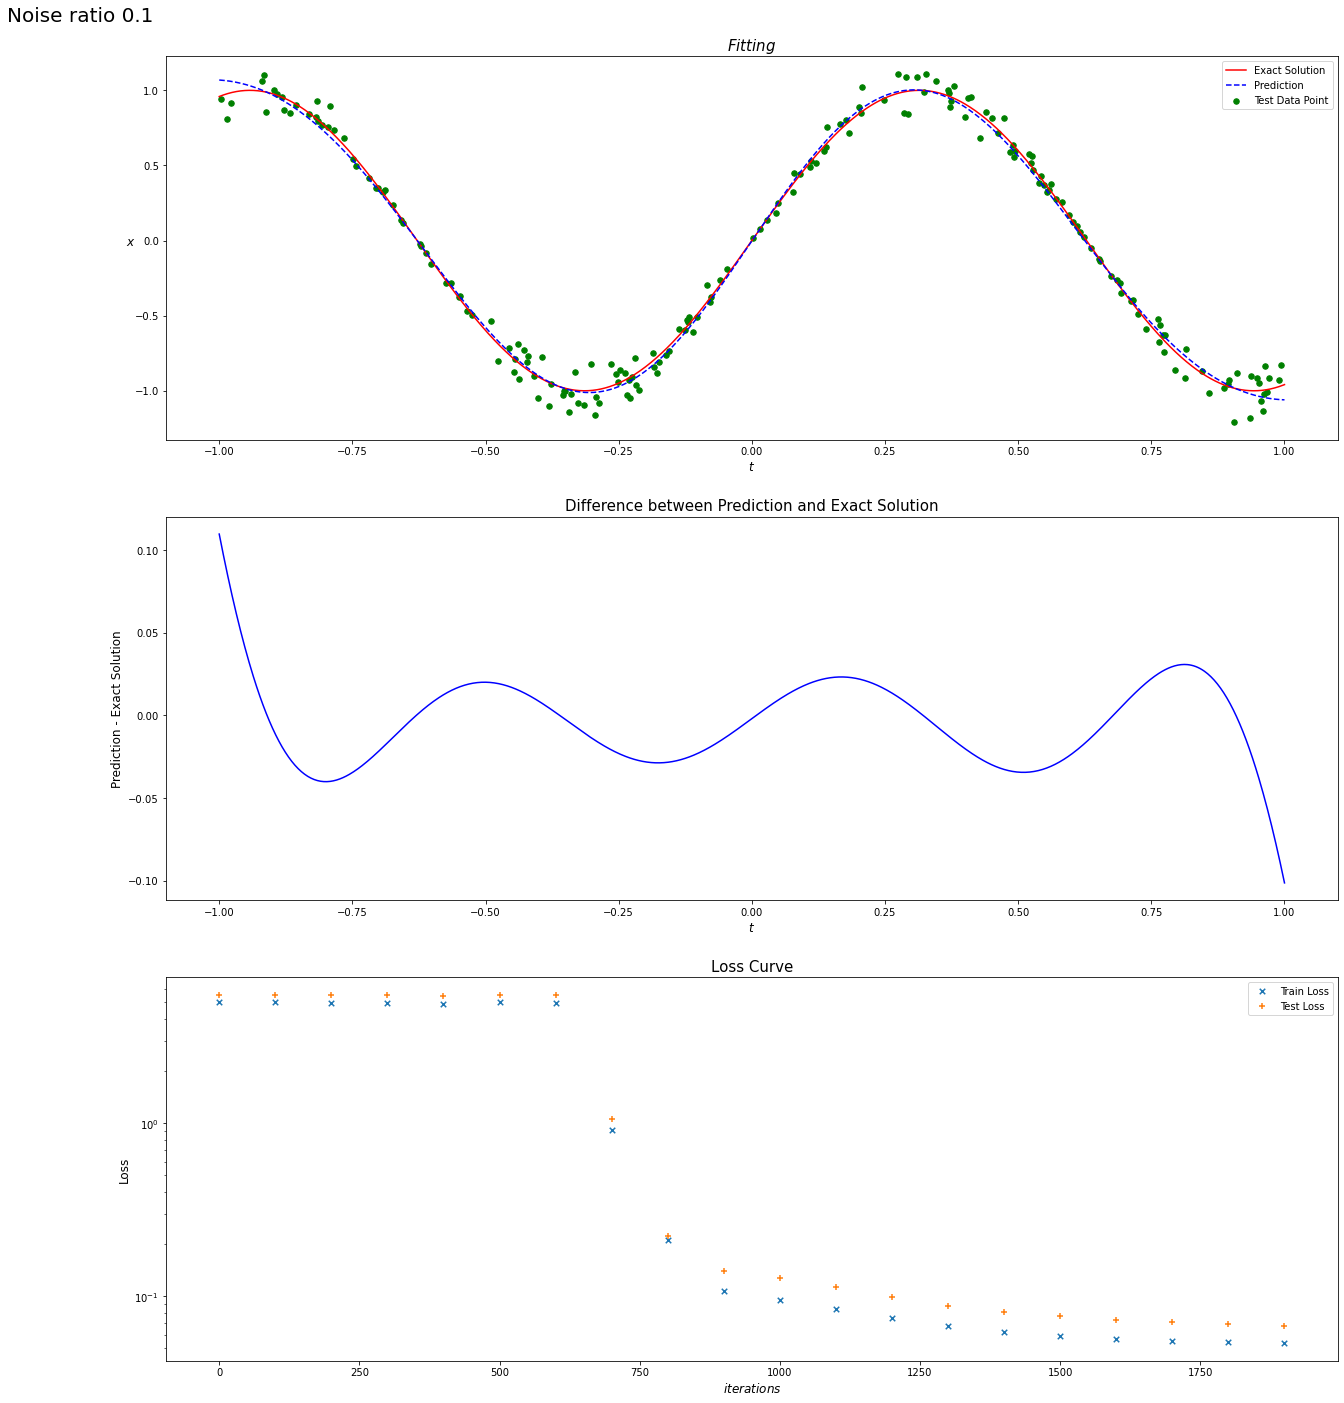

In [5]:
# Create data points and get random split of train, test data sets by index slicing
n_total = 1000
train_ratio = 0.8
n_train = int(n_total * train_ratio)

t_all = np.linspace(-1, 1, n_total)
noise = np.random.normal(loc=0.0, scale=0.1, size=t_all.shape)
x_all = np.sin(5 * t_all) * (1 + noise)
x_true = np.sin(5 * t_all)

train_indices = np.zeros(t_all.size, dtype=bool)
train_indices[:n_train] = True
np.random.shuffle(train_indices)

t_train = t_all[train_indices]
x_train = x_all[train_indices]
t_train = tf.reshape(tf.cast(t_train, dtype = tf.float32), shape=(-1, 1))
x_train = tf.reshape(tf.cast(x_train, dtype = tf.float32), shape=(-1, 1))

t_test = t_all[~train_indices]
x_test = x_all[~train_indices]
t_test = tf.reshape(tf.cast(t_test, dtype = tf.float32), shape=(-1, 1))
x_test = tf.reshape(tf.cast(x_test, dtype = tf.float32), shape=(-1, 1))

model = NeuralNet(
    t_train=t_train, x_train=x_train, t_test=t_test, x_test=x_test,
    layers=[100, 100, 100, 1], t_min=t_all.min(0), t_max=t_all.max(0))

start_time = time.time()
model.train(2000, learning_rate=0.01, idxOpt=1)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

pred_all = model.net(tf.reshape(tf.cast(t_all, dtype=tf.float32), shape=(-1, 1))).numpy().flatten()
print('Norm of Differnece: %e' % (model.get_test_error().numpy()))

plot(t_all, x_all, pred_all, t_test, x_test, title="Noise ratio 0.1")

It: 0, Train Loss: 6.660e+00, Test Loss: 5.919e+00, Time: 0.20
It: 100, Train Loss: 6.592e+00, Test Loss: 6.040e+00, Time: 0.74
It: 200, Train Loss: 6.584e+00, Test Loss: 6.032e+00, Time: 0.72
It: 300, Train Loss: 6.565e+00, Test Loss: 6.010e+00, Time: 0.78
It: 400, Train Loss: 3.968e+00, Test Loss: 3.554e+00, Time: 0.72
It: 500, Train Loss: 1.447e+00, Test Loss: 1.299e+00, Time: 0.73
It: 600, Train Loss: 1.443e+00, Test Loss: 1.294e+00, Time: 0.62
It: 700, Train Loss: 1.441e+00, Test Loss: 1.290e+00, Time: 0.67
It: 800, Train Loss: 1.439e+00, Test Loss: 1.288e+00, Time: 0.65
It: 900, Train Loss: 1.438e+00, Test Loss: 1.287e+00, Time: 0.65
It: 1000, Train Loss: 1.438e+00, Test Loss: 1.286e+00, Time: 0.62
It: 1100, Train Loss: 1.437e+00, Test Loss: 1.286e+00, Time: 0.73
It: 1200, Train Loss: 1.437e+00, Test Loss: 1.285e+00, Time: 0.62
It: 1300, Train Loss: 1.436e+00, Test Loss: 1.285e+00, Time: 0.60
It: 1400, Train Loss: 1.436e+00, Test Loss: 1.285e+00, Time: 0.60
It: 1500, Train Loss: 

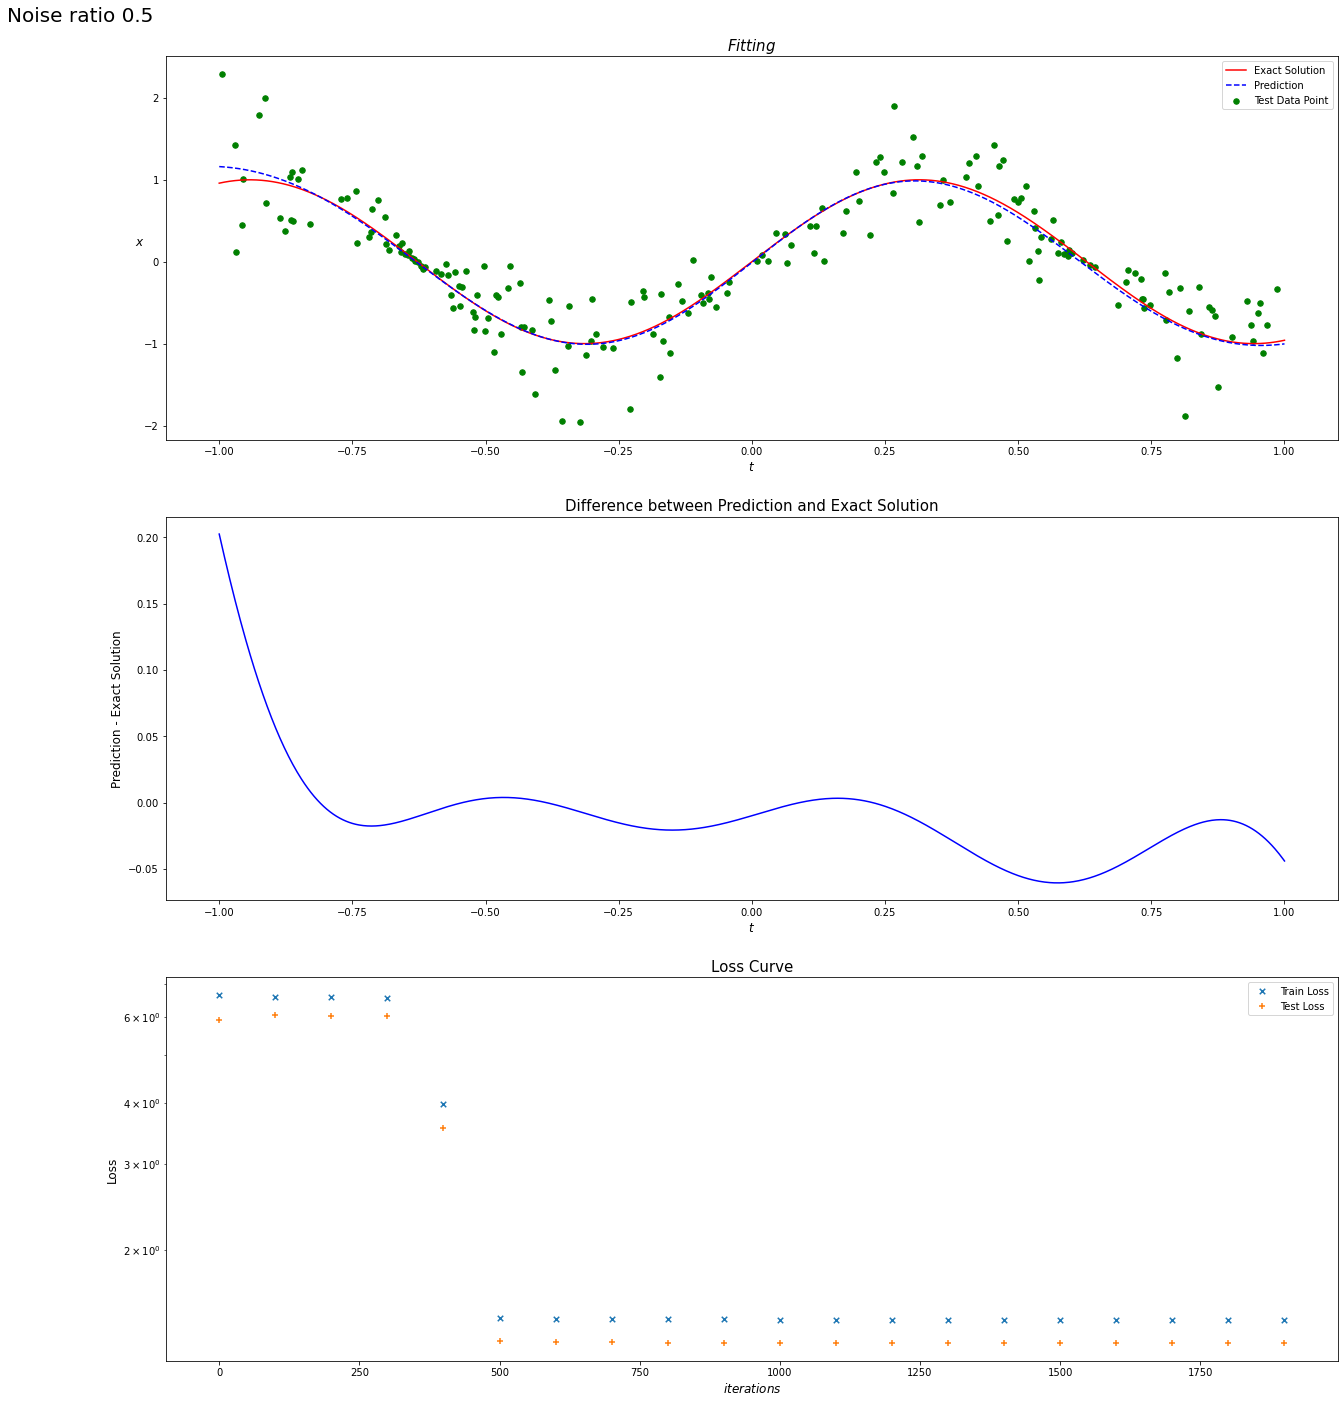

In [6]:
# Create data points and get random split of train, test data sets by index slicing
n_total = 1000
train_ratio = 0.8
n_train = int(n_total * train_ratio)

t_all = np.linspace(-1, 1, n_total)
noise = np.random.normal(loc=0.0, scale=0.5, size=t_all.shape)
x_all = np.sin(5 * t_all) * (1 + noise)
x_true = np.sin(5 * t_all)

train_indices = np.zeros(t_all.size, dtype=bool)
train_indices[:n_train] = True
np.random.shuffle(train_indices)

t_train = t_all[train_indices]
x_train = x_all[train_indices]
t_train = tf.reshape(tf.cast(t_train, dtype = tf.float32), shape=(-1, 1))
x_train = tf.reshape(tf.cast(x_train, dtype = tf.float32), shape=(-1, 1))

t_test = t_all[~train_indices]
x_test = x_all[~train_indices]
t_test = tf.reshape(tf.cast(t_test, dtype = tf.float32), shape=(-1, 1))
x_test = tf.reshape(tf.cast(x_test, dtype = tf.float32), shape=(-1, 1))

model = NeuralNet(
    t_train=t_train, x_train=x_train, t_test=t_test, x_test=x_test,
    layers=[100, 100, 100, 1], t_min=t_all.min(0), t_max=t_all.max(0))

start_time = time.time()
model.train(2000, learning_rate=0.01, idxOpt=1)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

pred_all = model.net(tf.reshape(tf.cast(t_all, dtype=tf.float32), shape=(-1, 1))).numpy().flatten()
print('Norm of Differnece: %e' % (model.get_test_error().numpy()))

plot(t_all, x_all, pred_all, t_test, x_test, title="Noise ratio 0.5")